# Figure for paper:
## Equivalent width of Helium versus Orbital Phase


Author: Michael Gully-Santiago  
Date: February 7, 2022

This notebook adapts previous notebooks made by Aishwarya Ganesh, see `08b_...` in the `01_exploratory/` notebook directory.

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import warnings
import matplotlib.pyplot as plt
import astropy.units as u
from muler.hpf import HPFSpectrum
import seaborn as sns

from specutils.fitting import fit_continuum
from astropy.modeling import models

from astropy.time import Time
import lightkurve as lk
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper', font_scale=1.2)

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message="Model is linear in parameters")

In [ ]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

### Read in the table of metadata

In [ ]:
#df = pd.read_csv('C:/Users/jojoa/GitHub/disperse/data/preliminary_results_He.csv')

In [ ]:
#df_raw = pd.read_csv('../../../blimp/data/tables/003_goldilocks_PSU_dropbox_1081x30_v1p0.csv')
df_raw = pd.read_csv('../../../blimp/notebooks/11_metadata_table_updates/helium_targets_goldilocks_PSU_exoarchive.csv')

## Addendum Jun 24, 2022

We want data from yesterday and don't want to recreate the entire Blimp dataset.  Let's just fetch it automatically:

In [ ]:
def get_metadata_from_fits(filenames, dynamic_only=True):
    df_out = pd.DataFrame()
    for file in tqdm(filenames):
        hdu = fits.open(file)
        hdr = hdu[0].header
        
        # Remove duplicate keys like `HISTORY`
        columns = np.array(list(hdr.keys()))
        _, indices, counts = np.unique(columns, return_index=True, return_counts=True)
        columns = columns[np.isin(columns, columns[indices[counts==1]])]
        df = pd.Series({col:hdr[col] for col in columns }).to_frame().T
        df['file']=file
        df_out = df_out.append(df, ignore_index=True)
        hdu.close()
    
    # Only keep columns that change in time
    if dynamic_only:
        dynamic_columns = df_out.apply(lambda x: len(pd.unique(x))) != 1
        df_out = df_out[dynamic_columns[dynamic_columns].index.values]
        
    return df_out

In [ ]:
tacc_path = '/Volumes/pecos/HPF/TACC'

In [ ]:
exosphere_program_ids = ['UT19-2-013', 'UT19-3-009',  'UT20-1-012', 
                         'UT20-2-011', 'UT20-3-009', 'UT21-1-010', 'UT22-2-019']

In [ ]:
tacc_goldilocks_files = []
for prog_id in exosphere_program_ids:
    print(prog_id)
    pattern = tacc_path + '/{}/*spectra.fits'.format(prog_id)
    filenames = glob.glob(pattern, recursive=True)
    tacc_goldilocks_files += filenames

In [ ]:
len(tacc_goldilocks_files)

In [20]:
%%capture
df_raw = get_metadata_from_fits(tacc_goldilocks_files)

In [21]:
len(df_raw)

1013

In [30]:
df_raw['full_path'] = tacc_goldilocks_files

In [31]:
target_mask = df_raw.OBJECT.str.contains('67')
df = df_raw[target_mask]

In [32]:
df.OBJECT.value_counts()

HAT-P-67b_IN_1             28
HAT-P-67b_IN_2             14
hat-p-67b                  12
HAT-P-67b_IN_3              9
HAT-P-67b_OUT_same3         9
HAT-P-67b_OUT_1_before1     4
HAT-P-67b_OUT_3_after2      4
HAT-P-67b_OUT_2_b2          4
HAT-P-67b_OUT_1_a2          4
HAT-P-67b_OUT_1_a1          4
HAT-P-67b_OUT_1_b1          4
HAT-P-67b_OUT_1_b2          4
Hat-P-67                    4
HAT-P-67b_OUT_3_after1      4
HAT-P-67b_OUT_3_before1     4
HAT-P-67b_OUT_2_after2      4
HAT-P-67b_OUT_2_after1      4
HAT-P-67b_OUT_2_before1     4
HAT-P-67b_OUT_2_before2     4
HAT-P-67b_OUT_1_after1      4
HAT-P-67b_OUT_3_before2     3
HAT-P-67b_EPOCH1            3
HAT-P-67b_EPOCH4            3
HAT-P-67b_EPOCH2            3
HAT-P-67b_EPOCH3            3
Name: OBJECT, dtype: int64

## Assign the orbital phase

Let's compute the normalized phase shifted so that the transit midpoint always occurs at zero while also seeing the light curve before and after the midpoint.

$$\phi=\frac{\mod(t-T_c+\frac{P}{2}\;,P)}{P} -0.5$$ 

In [33]:
target_name = 'HAT-P-67b'
orbital_period = 4.81010250
t_c = 2455961.38467
t_c_btjd = t_c - 2457000.0 #neg value means discovered before TESS
t_14_hours = 6.989 # transit duration in hours
t_14_days = t_14_hours/24.0
t_14_orb_phase = t_14_days / orbital_period

In [34]:
df['JD'] = df['DATE-OBS'].apply(lambda x: Time(x).jd)
df['BTJD'] = df.JD -2457000.0

df['phase'] = np.mod(df.BTJD-t_c_btjd+(orbital_period*0.5),orbital_period)-0.5*orbital_period
df['normalized_phase']=(df['phase']/orbital_period)
df['in_transit_flag']=np.abs(df['normalized_phase']) < t_14_orb_phase/2.0

In [36]:
def get_full_path(fn, trimester, base_path=None):
    """Get the full path to the data synced from TACC
    
    Parameters:
    ----------
    
    fn (str): The Goldilocks or PSU reduced 1D filename
    trimester (str): The trimester identifier "QPROG" from the FITS header
    base_path: The root directory to the TACC-synced data
    """
    
    return str(base_path) + '/' + str(trimester) + '/' + str(fn)

In [37]:
#df['full_path'] = df.apply(lambda x: get_full_path(x.file_basename_Goldilocks, x.QPROG, base_path=base_path), axis=1)

Assign the "campaigns" surrounding individual transits.

In [39]:
from astropy.time import Time
import astropy.units as u

In [41]:
hpf_t0 = Time(['2017-11-29T17:00:00.0']) # 17h UTC is ~noon in Fort Davis
JD_values = df['JD'].values
night_number = np.floor(JD_values - hpf_t0.jd).astype(int)
time_from_local_midnight = np.round(np.mod(JD_values - hpf_t0.jd, 1)*24.0 - 12.0, decimals=2)
df.insert(0, 'night_number', night_number)
nightly_timestamp = (hpf_t0 + df.night_number*u.day).iso
df.insert(1, 'night_of', [string[0:10] for string in nightly_timestamp])
df.insert(2, 'local_hour', time_from_local_midnight) # Negative means time until local midnight

In [42]:
df

,night_number,night_of,local_hour,ORIGIN,DATE,OBJECT,OBSERVER,OBSTYPE,DATE-OBS,CAL-OBJ,...,ADSUBI,AVRF3P0V,AVRF3P0I,full_path,JD,BTJD,phase,normalized_phase,in_transit_flag,campaign
176,879,2020-04-26,1.49,astropy.fits,2020-04-27T06:28:47,HAT-P-67b_OUT_1_before1,CFB,Sci,2020-04-27T06:29:11.640106,dark,...,NaN,NaN,NaN,/Volumes/pecos/HPF/TACC/UT20-2-011/Goldilocks_...,2.458967e+06,1966.770274,-0.928459,-0.193023,False,
177,879,2020-04-26,1.58,astropy.fits,2020-04-27T06:34:37,HAT-P-67b_OUT_1_before1,CFB,Sci,2020-04-27T06:35:03.305245,dark,...,NaN,NaN,NaN,/Volumes/pecos/HPF/TACC/UT20-2-011/Goldilocks_...,2.458967e+06,1966.774344,-0.924389,-0.192177,False,
178,879,2020-04-26,1.68,astropy.fits,2020-04-27T06:40:29,HAT-P-67b_OUT_1_before1,CFB,Sci,2020-04-27T06:40:55.338979,dark,...,NaN,NaN,NaN,/Volumes/pecos/HPF/TACC/UT20-2-011/Goldilocks_...,2.458967e+06,1966.778418,-0.920314,-0.191329,False,
179,879,2020-04-26,1.78,astropy.fits,2020-04-27T06:46:19,HAT-P-67b_OUT_1_before1,CFB,Sci,2020-04-27T06:46:47.563456,dark,...,NaN,NaN,NaN,/Volumes/pecos/HPF/TACC/UT20-2-011/Goldilocks_...,2.458967e+06,1966.782495,-0.916238,-0.190482,False,
180,880,2020-04-27,1.18,astropy.fits,2020-04-28T06:10:02,HAT-P-67b_IN_1,CFB,Sci,2020-04-28T06:10:31.377897,dark,...,NaN,NaN,NaN,/Volumes/pecos/HPF/TACC/UT20-2-011/Goldilocks_...,2.458968e+06,1967.757308,0.058575,0.012178,True,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,1665,2022-06-21,3.69,astropy.fits,2022-06-22T08:41:08,HAT-P-67b_EPOCH2,CFB,Sci,2022-06-22T08:41:36.193699,dark,...,0.042266,3.028515,-0.042598,/Volumes/pecos/HPF/TACC/UT22-2-019/Goldilocks_...,2.459753e+06,2752.862224,1.116784,0.232175,False,
1007,1665,2022-06-21,3.79,astropy.fits,2022-06-22T08:46:55,HAT-P-67b_EPOCH2,CFB,Sci,2022-06-22T08:47:17.355654,dark,...,0.042266,3.0289,-0.042598,/Volumes/pecos/HPF/TACC/UT22-2-019/Goldilocks_...,2.459753e+06,2752.866173,1.120733,0.232996,False,
1010,1666,2022-06-22,3.46,astropy.fits,2022-06-23T08:27:12,HAT-P-67b_EPOCH3,CFB,Sci,2022-06-23T08:27:34.605231,dark,...,0.042266,3.028515,-0.042598,/Volumes/pecos/HPF/TACC/UT22-2-019/Goldilocks_...,2.459754e+06,2753.852484,2.107044,0.438046,False,
1011,1666,2022-06-22,3.56,astropy.fits,2022-06-23T08:32:58,HAT-P-67b_EPOCH3,CFB,Sci,2022-06-23T08:33:26.392145,dark,...,0.042266,3.028592,-0.042598,/Volumes/pecos/HPF/TACC/UT22-2-019/Goldilocks_...,2.459754e+06,2753.856555,2.111115,0.438892,False,


In [43]:
df['campaign'] = ''

df.campaign[df.night_of.isin(['2020-04-26', '2020-04-27', '2020-04-28'])] = 'April 2020'
df.campaign[df.night_of.str.contains('2020-05')] = 'May 2020'
df.campaign[df.night_of.str.contains('2020-06')] = 'June 2020'
df.campaign[df.campaign==''] = 'P4 (July 2020-March 2021)'

## Conduct Helium analysis

Derive median uncertainty

In [44]:
df = df.reset_index(drop=True)

In [45]:
threshold = 0.035 # SNR per pixel should be better than ~30:1

In [46]:
df['stddev_order19'] = 0.0
for i, fn in enumerate(df.full_path.values):
    spec_raw = HPFSpectrum(file=fn, order=19)
    spec = spec_raw.sky_subtract(method='vector').remove_nans().trim_edges().deblaze().normalize()
    spec = spec.apply_boolean_mask(spec.wavelength<(10827*u.Angstrom))
    df.loc[i, 'stddev_order19'] = np.nanstd(spec.flux.value)

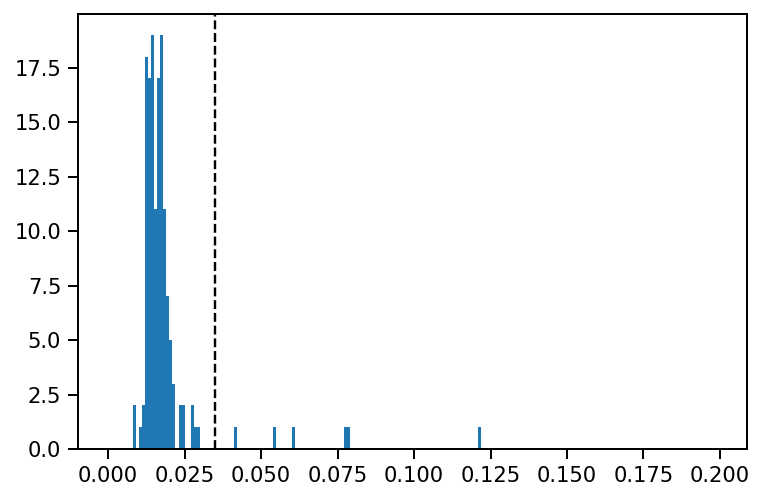

In [49]:
plt.hist(df.stddev_order19, bins=np.arange(0, 0.2, 0.001));
plt.axvline(threshold, linestyle='dashed', color='k')

In [50]:
high_snr = df.stddev_order19 < threshold

In [51]:
df = df[high_snr].reset_index(drop=True)

## Post-process the spectra
Apply the same method to each spectrum.  We will define some continuum indices to flatten to.

In [52]:
blue_limits = (10826.5*u.Angstrom, 10827.5*u.Angstrom)
red_limits = (10839.2*u.Angstrom, 10840.2*u.Angstrom)

window = [blue_limits, red_limits]

In [53]:
def flatten_to_regions(spec, windows, polynomial_order=None):
    """Flatten a spectrum to featureless continuum input regions
    
    Parameters:
    ----------
    spec (Spectrum1D-like):
        A spectrum to be flattened
    window (list of tuples):
        A list of pairs of boundaries at which the straight line will be computed
    polynomial_order (int):
        The polynomial order of the fit (defaults to 1-- straight line)
    """
    if polynomial_order is None:
        polynomial_order = 1
    linear_model = models.Chebyshev1D(polynomial_order)
    continuum_func = fit_continuum(spec, window=windows, model=linear_model)
    return spec/continuum_func(spec.wavelength)

In [54]:
spec_list = []
for fn in tqdm(df.full_path.values):
    spec_raw = HPFSpectrum(file=fn, order=19)
    spec =  spec_raw.sky_subtract(method='vector')\
                    .remove_nans()\
                    .trim_edges()\
                    .deblaze()\
                    .mask_tellurics(threshold=0.95, dilation=3)\
                    .barycentric_correct().normalize()
    spec = flatten_to_regions(spec, window)
    spec_list.append(spec)

  0%|          | 0/140 [00:00<?, ?it/s]

In [55]:
len(spec_list)

140

In [56]:
feature_indices = (10832.3, 10834.2)

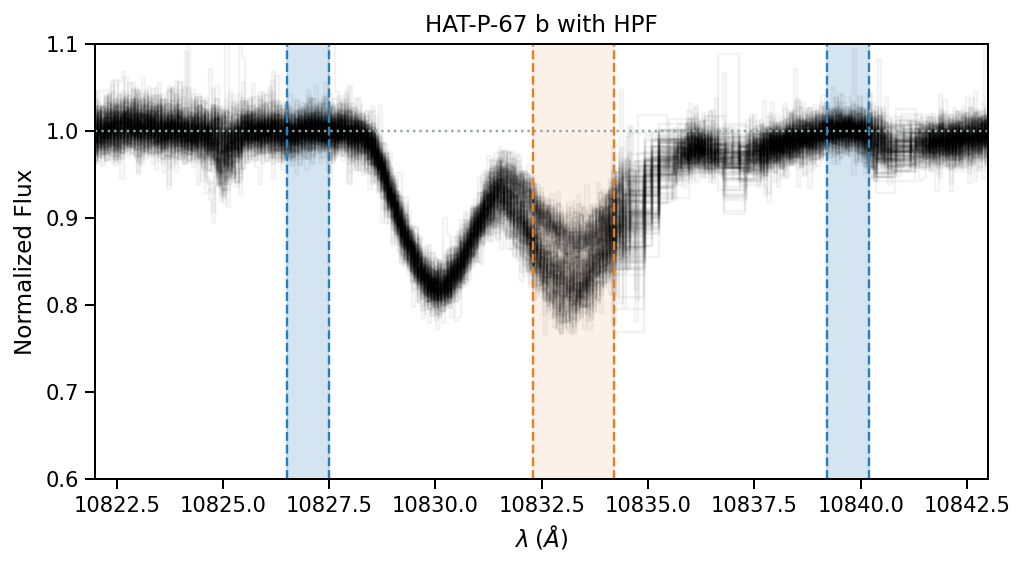

In [57]:
fig, ax = plt.subplots(figsize=(8, 4))

for spec in spec_list:
    spec.plot(ax=ax, ylo=0, color='k', alpha=0.05)


ax.set_xlim(10822, 10843)
ax.axhline(1.0, linestyle='dotted', color='#95a5a6')

ax.axvline(blue_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(blue_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in blue_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.axvline(feature_indices[0], linestyle='dashed', color='#e67e22')
ax.axvline(feature_indices[1], linestyle='dashed', color='#e67e22')
ax.fill_between(feature_indices, [2, 2], alpha=0.1, color='#e67e22', zorder=0)

ax.axvline(red_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(red_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in red_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.set_xlabel('$\lambda\;(\AA)$')
ax.set_ylabel('Normalized Flux')
ax.set_title('HAT-P-67 b with HPF')

ax.set_ylim(0.6, 1.1)
plt.savefig('../../figures/HAT_P_67b_He_spectrum.jpg', bbox_inches='tight', dpi=300);

Neat, lets sort those by campaign

In [58]:
campaign = 'June 2020'

In [59]:
unique_nights = df[df.campaign==campaign].night_of.unique()
unique_nights

array(['2020-06-12', '2020-06-13', '2020-06-14', '2020-06-15',
       '2020-06-17'], dtype=object)

In [60]:
#pal = sns.color_palette("rocket", n_colors=len(unique_nights))
pal = sns.color_palette("cubehelix",n_colors=len(unique_nights))

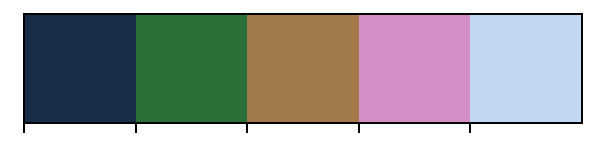

In [61]:
sns.palplot(pal)

In [62]:
color_dict = {night:pal[i] for i, night in enumerate(unique_nights)}

In [63]:
color_dict

{'2020-06-12': (0.09641540616370546, 0.17728671859553138, 0.28347363185399654),
 '2020-06-13': (0.17004232121057958, 0.43679759647517286, 0.22372555555555548),
 '2020-06-14': (0.6328422475018423, 0.4747981096220677, 0.29070209208025455),
 '2020-06-15': (0.8299576787894204, 0.5632024035248271, 0.7762744444444445),
 '2020-06-17': (0.7632674462838152, 0.850242277575182, 0.9515539762051686)}

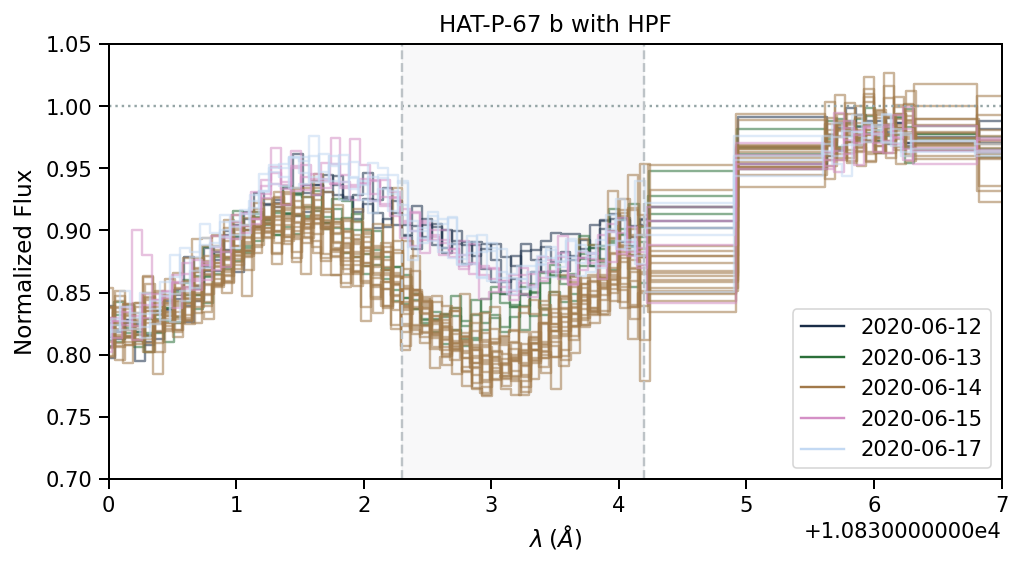

In [64]:
fig, ax = plt.subplots(figsize=(8, 4))

night_of = 'junk'
for i, spec in enumerate(spec_list):
    metadata = df.iloc[i]
    if metadata.campaign == campaign:
        color = color_dict[metadata.night_of]
        label = metadata.night_of if (night_of!=metadata.night_of) else None
        spec.plot(ax=ax, ylo=0, alpha=0.55, label=None, color=color)
        night_of = metadata.night_of


# Hack to get the labels to be bold.
night_of = 'junk'
for i, spec in enumerate(spec_list):
    metadata = df.iloc[i]
    if metadata.campaign == campaign:
        color = color_dict[metadata.night_of]
        label = metadata.night_of if (night_of!=metadata.night_of) else None
        (spec*-1).plot(ax=ax, ylo=0, alpha=1, label=label, color=color)
        night_of = metadata.night_of
        
        
plt.legend(loc='best')
ax.set_xlim(10830, 10837)
ax.axhline(1.0, linestyle='dotted', color='#95a5a6')

ax.axvline(blue_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(blue_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in blue_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.axvline(feature_indices[0], linestyle='dashed', color='#bdc3c7')
ax.axvline(feature_indices[1], linestyle='dashed', color='#bdc3c7')
ax.fill_between(feature_indices, [2, 2], alpha=0.1, color='#bdc3c7', zorder=0)

ax.axvline(red_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(red_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in red_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.set_xlabel('$\lambda\;(\AA)$')
ax.set_ylabel('Normalized Flux')
ax.set_title('HAT-P-67 b with HPF')

ax.set_ylim(0.7, 1.05)
fn_out = '../../figures/HAT_P_67b_He_{}.jpg'.format(campaign)
fn_out = fn_out.replace(' ', '').replace('(', '').replace(')', '')
plt.savefig(fn_out, bbox_inches='tight', dpi=300);

Neat!  Let's make a transmission spectrum plot.

In [65]:
from muler.utilities import combine_spectra_misaligned

In [66]:
night1_spectra = [spec for i, spec in enumerate(spec_list) if df.iloc[i].night_of == '2020-06-12']
night2_spectra = [spec for i, spec in enumerate(spec_list) if df.iloc[i].night_of == '2020-06-13']
night3_spectra = [spec for i, spec in enumerate(spec_list) if df.iloc[i].night_of == '2020-06-14']
night4_spectra = [spec for i, spec in enumerate(spec_list) if df.iloc[i].night_of == '2020-06-15']
night5_spectra = [spec for i, spec in enumerate(spec_list) if df.iloc[i].night_of == '2020-06-17']

In [67]:
pixel_midpoints = spec_raw.wavelength.value

In [68]:
night1 = combine_spectra_misaligned(night1_spectra, pixel_midpoints=pixel_midpoints)
night2 = combine_spectra_misaligned(night2_spectra, pixel_midpoints=pixel_midpoints)
night3 = combine_spectra_misaligned(night3_spectra, pixel_midpoints=pixel_midpoints)
night4 = combine_spectra_misaligned(night4_spectra, pixel_midpoints=pixel_midpoints)
night5 = combine_spectra_misaligned(night5_spectra, pixel_midpoints=pixel_midpoints)

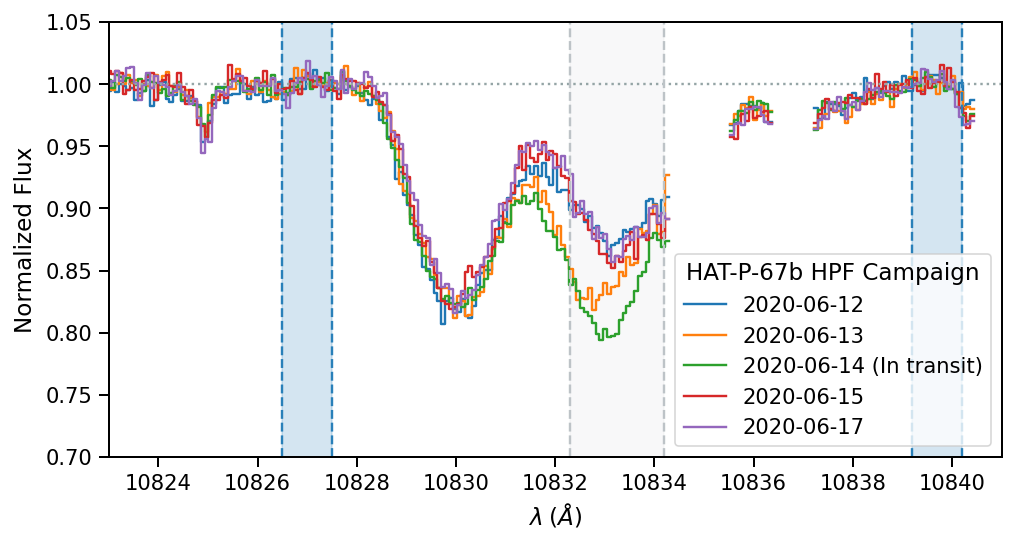

In [69]:
fig, ax = plt.subplots(figsize=(8, 4))
night1.plot(ax=ax, label='2020-06-12')
night2.plot(ax=ax, label='2020-06-13')
night3.plot(ax=ax, label='2020-06-14 (In transit)')
night4.plot(ax=ax, label='2020-06-15')
night5.plot(ax=ax, label='2020-06-17')


ax.set_xlim(10823, 10841)
ax.axhline(1.0, linestyle='dotted', color='#95a5a6')

ax.axvline(blue_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(blue_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in blue_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.axvline(feature_indices[0], linestyle='dashed', color='#bdc3c7')
ax.axvline(feature_indices[1], linestyle='dashed', color='#bdc3c7')
ax.fill_between(feature_indices, [2, 2], alpha=0.1, color='#bdc3c7', zorder=0)

ax.axvline(red_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(red_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in red_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.set_xlabel('$\lambda\;(\AA)$')
ax.set_ylabel('Normalized Flux')
ax.legend(title='HAT-P-67b HPF Campaign')

ax.set_ylim(0.7, 1.05)
plt.savefig('../../figures/HAT-P-67_June2020_clean.png', bbox_inches='tight', dpi=300)

Neat!  There is velocity structure there!

### Make a transmission spectrum in the planet rest frame

Can we shift the spectrum into the planet rest-frame?  Divide the circumference by the period to get instantaneous tangential velocity.  Assume a circular orbit:

$$ v = \frac{2 \pi a}{P}$$

In [70]:
semi_major_axis = 0.06505 * u.AU

In [71]:
planet_speed_quantity = (2*np.pi*semi_major_axis)/(orbital_period*u.day)

In [72]:
planet_speed_quantity.to(u.km/u.second)

<Quantity 147.1243333 km / s>

In [73]:
planet_speed = planet_speed_quantity.to(u.km/u.second).value

Convention: Positive RVs are redshifted

In [74]:
df['RV_planet'] = planet_speed * np.sin(df.normalized_phase)

In [75]:
df.groupby(['night_of', 'in_transit_flag']).RV_planet.mean().to_frame()

,,RV_planet
night_of,in_transit_flag,
2020-04-26,False,-28.038899
2020-04-27,True,2.677058
2020-04-28,False,32.787522
2020-05-19,False,-53.678161
2020-05-20,False,-24.676725
2020-05-21,True,-0.867923
2020-05-22,False,35.863565
2020-05-23,False,64.660793
2020-06-12,False,-56.928633


### Let's make a transmission spectrum:

We'll simply use night 5 as the out-of-transit spectrum reference.

$$T(\lambda) = \frac{f_{out}-f_{in}}{f_{out}}$$



In [76]:
rp_over_rstar = 0.0834
transit_depth = rp_over_rstar**2
transit_depth

0.00695556

In [77]:
out_of_transit = night5

trans_3 = (out_of_transit.subtract(night3)).divide(out_of_transit)
trans_3 = trans_3.add(transit_depth*u.dimensionless_unscaled).multiply(100.0*u.dimensionless_unscaled)
trans_3 = trans_3.rv_shift(1.033626)

trans_2 = (out_of_transit.subtract(night2)).divide(out_of_transit)
trans_2 = trans_2.add(transit_depth*u.dimensionless_unscaled).multiply(100.0*u.dimensionless_unscaled)
trans_2 = trans_2.rv_shift(-27.756549)

trans_1 = (out_of_transit.subtract(night1)).divide(out_of_transit)
trans_1 = trans_1.add(transit_depth*u.dimensionless_unscaled).multiply(100.0*u.dimensionless_unscaled)
trans_1 = trans_1.rv_shift(-56.928633)

trans_4 = (out_of_transit.subtract(night4)).divide(out_of_transit)
trans_4 = trans_4.add(transit_depth*u.dimensionless_unscaled).multiply(100.0*u.dimensionless_unscaled)
trans_4 = trans_4.rv_shift(32.614198)

Convert to velocity space:

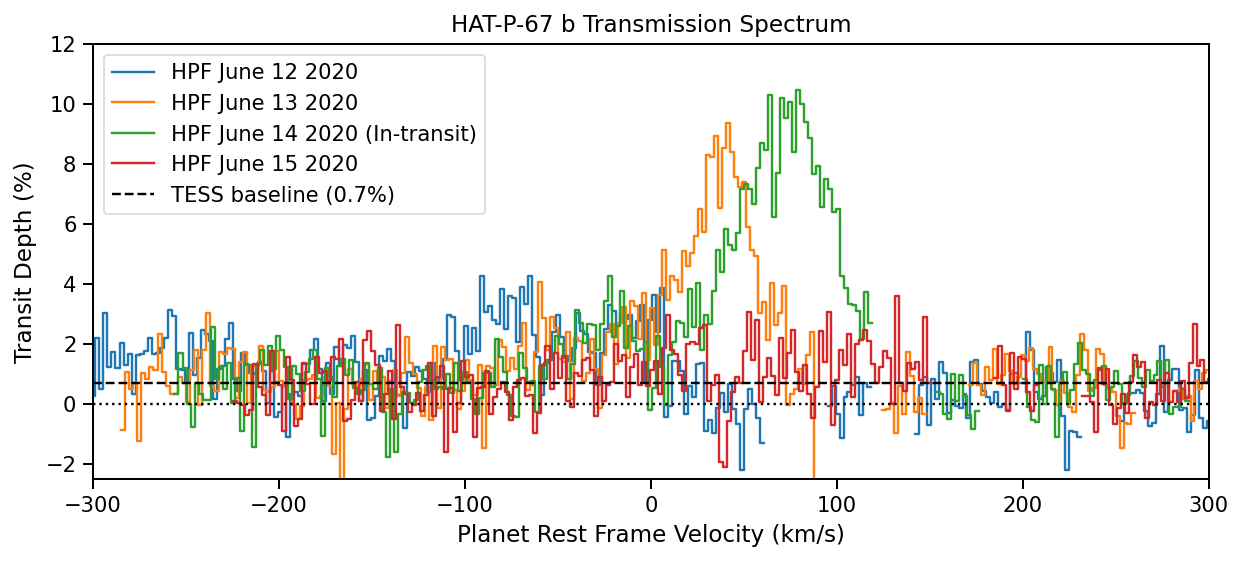

In [78]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.step(300_000*(trans_1.wavelength.value-10830)/10830, trans_1.flux.value, label='HPF June 12 2020')
ax.step(300_000*(trans_2.wavelength.value-10830)/10830, trans_2.flux.value, label='HPF June 13 2020')
ax.step(300_000*(trans_3.wavelength.value-10830)/10830, trans_3.flux.value, label='HPF June 14 2020 (In-transit)')
ax.step(300_000*(trans_4.wavelength.value-10830)/10830, trans_4.flux.value, label='HPF June 15 2020')
#ax.step(label='HPF June 13 2020', ax=ax)
#ax.step(label='HPF June 14 2020 (In-transit)', ax=ax)
#ax.step(label='HPF June 15 2020', ax=ax, alpha=0.2)



ax.axhline(0.0, color='k', linestyle='dotted')
ax.axhline(transit_depth*100, color='k', linestyle='dashed', label='TESS baseline (0.7%)')

ax.set_xlim(-300, 300)
ax.set_ylabel('Transit Depth (%)')
ax.set_xlabel('Planet Rest Frame Velocity (km/s)')
ax.legend()
ax.set_title('HAT-P-67 b Transmission Spectrum')
plt.ylim(-2.5, 12);

plt.savefig('../../figures/HAT_P_67b_transmission_June2020.png', bbox_inches='tight', dpi=300)

Awesome, that figure looks great!

Let's save one of those spectra as a demo to input into `p-winds`:

<AxesSubplot:title={'center':'HPF Spectrum'}, xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

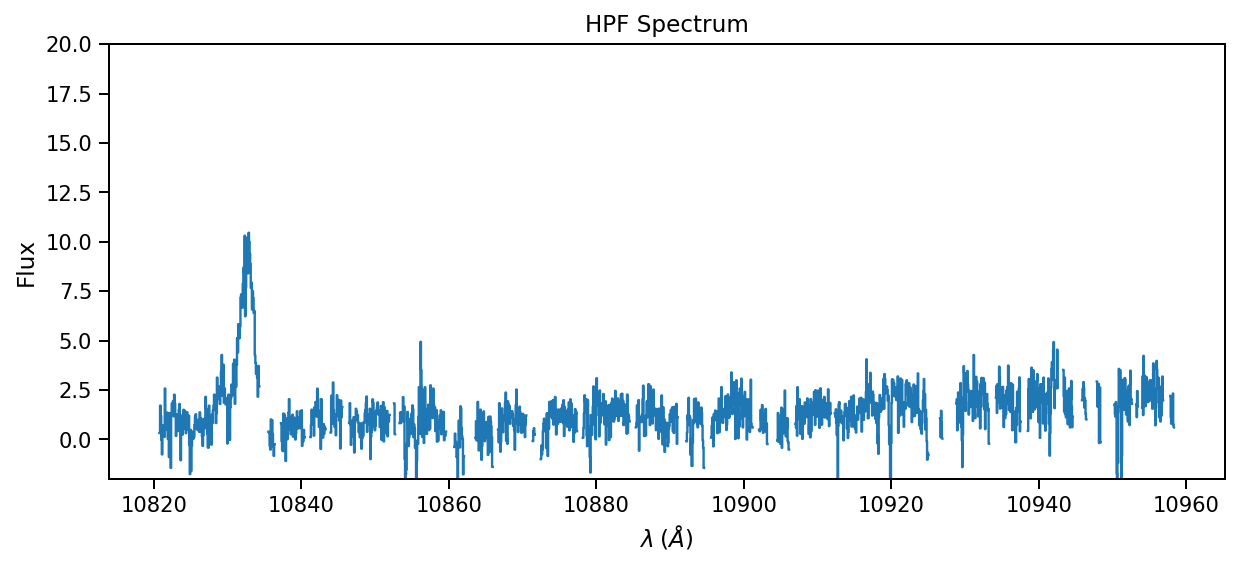

In [79]:
trans_3.plot(ylo=-2, yhi=20)


In [80]:
trans_3 = trans_3.remove_nans()

In [81]:
df_out.flux.std()

NameError: name 'df_out' is not defined

In [ ]:
df_out = pd.DataFrame({'wl':trans_3.wavelength.value, 'flux':trans_3.flux.value})

In [ ]:
df_out.to_csv('../../data/HPF/HPF_HAT_P_67_20200614_exosphere.csv', index=False)

In [ ]:
#! tail ../../data/HPF/HPF_HAT_P_67_20200614_exosphere.csv

In [ ]:
df.groupby(['night_of', 'in_transit_flag']).normalized_phase.mean().to_frame()

Ok, neat, we can see where the Telluric absorption resides, we have masked it for now.

## Compute Equivalent Width

In [82]:
ews = []
for i, spec in tqdm(enumerate(spec_list), total=len(spec_list)):
    ew = spec.measure_ew(lower=feature_indices[0], upper=feature_indices[1])
    ews.append(ew)

  0%|          | 0/140 [00:00<?, ?it/s]

In [83]:
df['ew'] = [ew.value for ew in ews]

## Plot the EW versus time and orbital phase

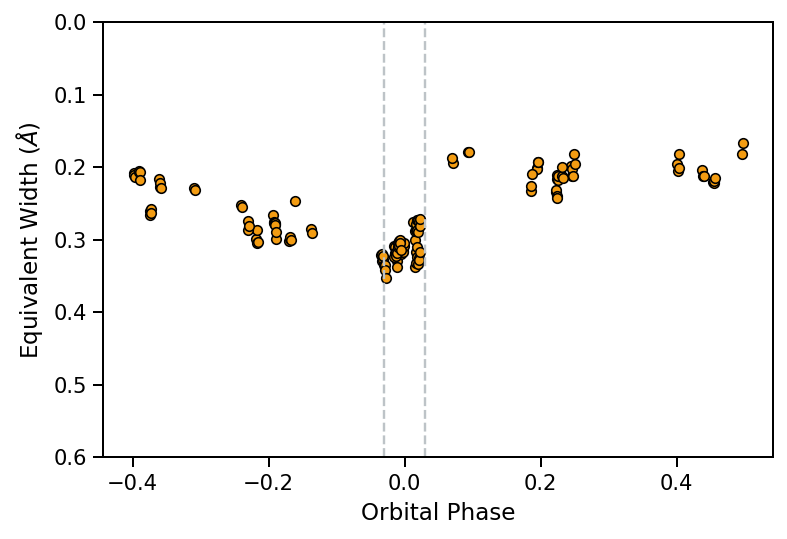

In [84]:
plt.scatter(df.normalized_phase, df.ew, ec='k', color='#f39c12')

plt.ylim(0.6, 0)
plt.axvline(-t_14_orb_phase/2, linestyle='dashed', color='#bdc3c7')
plt.axvline(+t_14_orb_phase/2, linestyle='dashed', color='#bdc3c7')
plt.xlabel('Orbital Phase');
plt.ylabel('Equivalent Width $(\AA)$');

Neat! We see an apparent asymmetric-in-orbital-phase absorption profile.

## Group the individual exposures into visits

In [85]:
gb = df.groupby(['night_of', 'in_transit_flag'])

In [86]:
mean_cols = gb.aggregate({'ew':np.mean, 'BTJD':np.mean, 'normalized_phase':np.mean, 
                          'campaign':lambda x:np.unique(x)[0]})

In [87]:
std_cols = gb.aggregate({'ew':np.std, 'BTJD':lambda x: np.ptp(x)/2, 
                         'normalized_phase':lambda x: np.ptp(x)/2, 'night_number':len})\
            .rename(columns={'ew':'ew_unc', 
                             'BTJD':'BTJD_range', 
                             'normalized_phase':'phase_range',
                             'night_number':'N_exposures'})

In [88]:
df_agg = pd.concat([mean_cols, std_cols], axis=1).sort_values('BTJD').reset_index()

Place a minimum EW uncertainty:

In [89]:
systematic_noise_floor = 0.003

In [90]:
df_agg.ew_unc[df_agg.ew_unc.isna()| (df_agg.ew_unc<systematic_noise_floor)] = systematic_noise_floor

In [91]:
def repeat_plot(df_agg, color, label):
    """Repeat the plot elements"""
    plt.scatter(df_agg.normalized_phase, df_agg.ew, ec='k', color=color, s=75, label=label)
    plt.errorbar(df_agg.normalized_phase, df_agg.ew, yerr=df_agg.ew_unc, xerr=df_agg.phase_range,linestyle='none', color='k', 
             barsabove=True, capsize=2, zorder=0)

In [92]:
campaigns = ['April 2020', 'May 2020', 'June 2020', 'P4 (July 2020-March 2021)']
colors = ['#f39c12', '#27ae60', '#3498db', '#8e44ad']

In [93]:
sns.set_context('talk', font_scale=1.0)

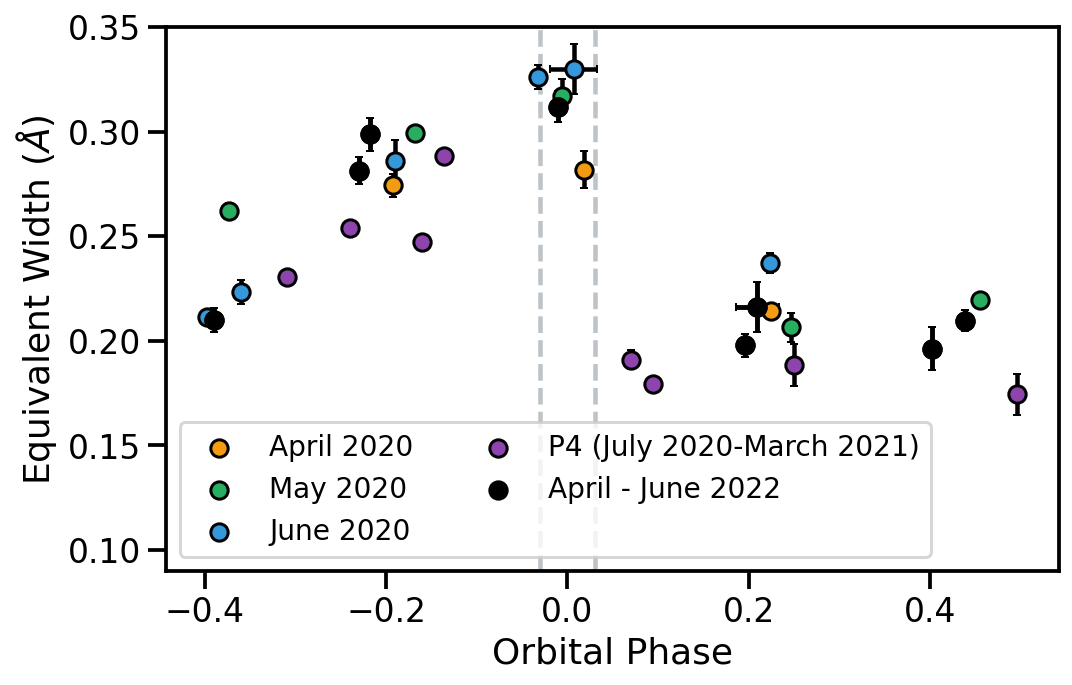

In [100]:
plt.figure(figsize=(8,5))

for label, color in zip(campaigns, colors):
    repeat_plot(df_agg[df_agg.campaign==label], color, label)
    
repeat_plot(df_agg[df_agg.night_of.str.contains('2022')], 'black', 'April - June 2022')

plt.ylim(0.09, 0.35)
plt.axvline(-t_14_orb_phase/2, linestyle='dashed', color='#bdc3c7', zorder=-1)
plt.axvline(+t_14_orb_phase/2, linestyle='dashed', color='#bdc3c7', zorder=-1)
plt.xlabel('Orbital Phase');
plt.ylabel('Equivalent Width $(\AA)$')
plt.legend(loc='lower left', ncol=2, fontsize=14)
plt.savefig('../../figures/HAT_P_67b_Helium10830EW_byCampaign.jpg', bbox_inches='tight', dpi=300, );

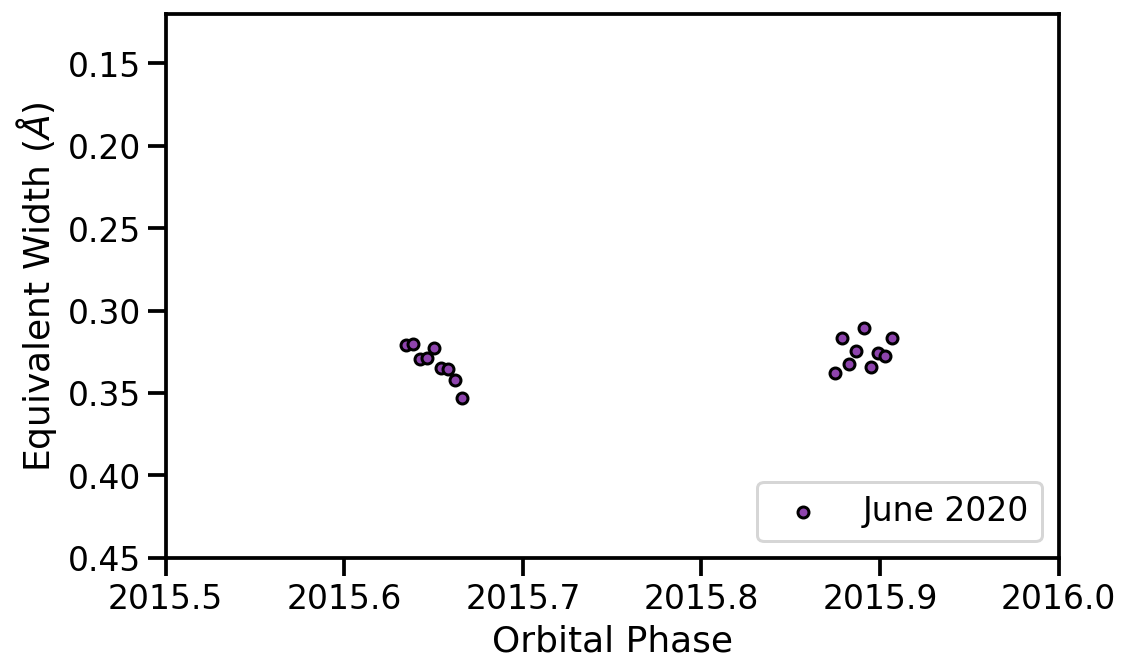

In [95]:
plt.figure(figsize=(8,5))

label = 'June 2020'
mask = df.campaign == label
plt.scatter(df.BTJD[mask], df.ew[mask], ec='k', color=color, s=30, label=label)



plt.legend(loc='lower right')
plt.ylim(0.45, 0.12)
plt.xlim(2015.5, 2016.0)
#plt.axvline(-t_14_orb_phase/2, linestyle='dashed', color='#bdc3c7', zorder=-1)
#plt.axvline(+t_14_orb_phase/2, linestyle='dashed', color='#bdc3c7', zorder=-1)
plt.xlabel('Orbital Phase');
plt.ylabel('Equivalent Width $(\AA)$')
plt.title('');

Neat! 

### Let's spot check the observability in 2022-2

In [112]:
df_2022 = pd.read_csv('../../data/2022_2_HET_observability.txt', sep='\t', names=['yy', 'mm', 'dd', 't1', 't2', 'd1', 
                                                                        't3', 't4', 'd2'])

In [124]:
df_2022['date_str'] = df_2022.yy.astype(str)+' '+df_2022['mm']+' ' +df_2022['dd'].astype(str)

In [138]:
df_2022['date1'] = pd.to_datetime(df_2022.date_str +' ' +df_2022.t1.fillna('00:00'))

In [160]:
df_2022['date2'] = pd.to_datetime(df_2022.date_str +' ' +df_2022.t3.str.replace(':60', ':59'))

In [ ]:
target_name = 'HAT-P-67b'
orbital_period = 4.81010250
t_c = 2455961.38467
t_c_btjd = t_c - 2457000.0 #neg value means discovered before TESS
t_14_hours = 6.989 # transit duration in hours
t_14_days = t_14_hours/24.0
t_14_orb_phase = t_14_days / orbital_period

In [ ]:
df['JD'] = df['DATE-OBS'].apply(lambda x: Time(x).jd)
df['BTJD'] = df.JD -2457000.0

df['phase'] = np.mod(df.BTJD-t_c_btjd+(orbital_period*0.5),orbital_period)-0.5*orbital_period
df['normalized_phase']=(df['phase']/orbital_period)
df['in_transit_flag']=np.abs(df['normalized_phase']) < t_14_orb_phase/2.0

In [163]:
df_2022['JD'] = df_2022['date2'].apply(lambda x: x.to_julian_date())
df_2022['BTJD'] = df_2022.JD -2457000.0


df_2022['phase'] = np.mod(df_2022.BTJD-t_c_btjd+(orbital_period*0.5),orbital_period)-0.5*orbital_period
df_2022['normalized_phase']=(df_2022['phase']/orbital_period)
df_2022['in_transit_flag']=np.abs(df_2022['normalized_phase']) < t_14_orb_phase/2.0

In [164]:
df_2022

,yy,mm,dd,t1,t2,d1,t3,t4,d2,date_str,date1,date2,JD,BTJD,phase,normalized_phase,in_transit_flag
0,2022,Jun,24,03:04,03:52,2874.0,07:47,09:21,5640,2022 Jun 24,2022-06-24 03:04:00,2022-06-24 07:47:00,2.459755e+06,2754.824306,-1.731237,-0.359917,False
1,2022,Jun,25,03:04,03:48,2634.0,07:43,09:17,5640,2022 Jun 25,2022-06-25 03:04:00,2022-06-25 07:43:00,2.459756e+06,2755.821528,-0.734015,-0.152599,False
2,2022,Jun,26,03:04,03:44,2394.0,07:39,09:13,5640,2022 Jun 26,2022-06-26 03:04:00,2022-06-26 07:39:00,2.459757e+06,2756.818750,0.263208,0.054720,False
3,2022,Jun,27,03:04,03:40,2154.0,07:35,09:09,5640,2022 Jun 27,2022-06-27 03:04:00,2022-06-27 07:35:00,2.459758e+06,2757.815972,1.260430,0.262038,False
4,2022,Jun,28,03:04,03:36,1914.0,07:31,09:05,5640,2022 Jun 28,2022-06-28 03:04:00,2022-06-28 07:31:00,2.459759e+06,2758.813194,2.257652,0.469356,False
5,2022,Jun,29,03:04,03:32,1674.0,07:27,09:01,5640,2022 Jun 29,2022-06-29 03:04:00,2022-06-29 07:27:00,2.459760e+06,2759.810417,-1.555228,-0.323325,False
6,2022,Jun,30,03:04,03:28,1434.0,07:23,08:57,5640,2022 Jun 30,2022-06-30 03:04:00,2022-06-30 07:23:00,2.459761e+06,2760.807639,-0.558006,-0.116007,False
7,2022,Jul,1,03:04,03:24,1194.0,07:19,08:53,5640,2022 Jul 1,2022-07-01 03:04:00,2022-07-01 07:19:00,2.459762e+06,2761.804861,0.439216,0.091311,False
8,2022,Jul,2,03:04,03:20,954.0,07:15,08:49,5640,2022 Jul 2,2022-07-02 03:04:00,2022-07-02 07:15:00,2.459763e+06,2762.802083,1.436438,0.298629,False
9,2022,Jul,3,03:04,03:16,714.0,07:11,08:45,5640,2022 Jul 3,2022-07-03 03:04:00,2022-07-03 07:11:00,2.459764e+06,2763.799306,-2.376442,-0.494052,False


## Plot the line profile

In [ ]:
df['ew']=df.ew.astype(np.float).values #change str to float
df['btjd']=df['jd']-2457000.0 #cut down JD to smaller scale

In [ ]:
sn_ratio=2
good_data_mask=(df.ew/df.ew_unc)>sn_ratio #signal to noise ratio

In [ ]:
df=df[good_data_mask]

In [ ]:
x_line=df['ew'].median() #calculate horizontal line going between in/out of transit points
x_line

In [ ]:
plt.figure(figsize=(25,6))
#plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd, df.ew, 'bo', markersize=10)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)

In [ ]:
plt.figure(figsize=(25,6))
#plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd, df.ew, 'bo', markersize=5)
plt.plot(df.btjd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=5) #change index to jd for time
#plt.ylim(0)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
#plt.savefig(f'../figures/{target_name}.jpg')

In [ ]:
df['phase']=np.mod(df.btjd-t_c_btjd+(orbital_period*0.5),orbital_period)-0.5*orbital_period
df['normalized_phase']=(df['phase']/orbital_period)

In [ ]:
df.describe() #max less than orbital period, normalized less than 1

In [ ]:
plt.figure(figsize=(25,6))

plt.errorbar(df.normalized_phase, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.normalized_phase[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.errorbar(df.normalized_phase-1, df.ew, yerr=df.ew_unc, fmt='b.')
#plt.plot(df.normalized_phase[in_transit_mask]-1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.errorbar(df.normalized_phase+1, df.ew, yerr=df.ew_unc, fmt='b.')
#plt.plot(df.normalized_phase[in_transit_mask]+1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.ylim(0.9,1.32)
plt.xlim(-.5,.5)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Normalized Orbital Phase', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
#plt.savefig(f'../figures/{target_name}.jpg')

In [ ]:
plt.figure(figsize=(25,6))

plt.plot(df.phase, df.ew, 'bo', markersize=10)
plt.plot(df.phase[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.plot(df.normalized_phase-1, df.ew, 'bo', markersize=10)
#plt.plot(df.normalized_phase[in_transit_mask]-1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.plot(df.normalized_phase+1, df.ew, 'bo', markersize=10)
#plt.plot(df.normalized_phase[in_transit_mask]+1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.ylim(0.9,1.32)
#plt.xlim(-2,2)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Normalized Orbital Phase', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
plt.savefig(f'../figures/{target_name}.jpg')

Let's define a variable called 'shifted' in two steps.

In [ ]:
second_half_mask = df.normalized_phase > 0.5
first_half_mask = ~second_half_mask

In [ ]:
df['shifted']=df.normalized_phase
df.shifted[second_half_mask]=df.shifted[second_half_mask]-1
df.shifted[second_half_mask]

In [ ]:
plt.figure(figsize=(25,6))
plt.errorbar(df.shifted, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.shifted[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
#plt.ylim(0.9,1.32)
plt.xlim(0,1)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Normalized Orbital Phase', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
#plt.savefig(f'../figures/{target_name}.jpg')

# Light curve analysis with TESS

In [ ]:
sr = lk.search_lightcurve(target_name)
lc_raw = sr[1].download()

In [ ]:
ax = lc_raw.normalize().plot(marker='.', linestyle='none')
#ax.set_ylim(0, 1.05)

In [ ]:
lc_folded = lc_raw.fold(period=orbital_period, epoch_time=t_c_btjd).normalize()
ax = lc_folded.plot(label = target_name+' TESS Sector 18')
plt.plot(df.phase, df.ew/np.median(df.ew), 'bo', markersize=2, label = 'HPF Helium Triplet')
plt.legend()
plt.xlim(-.5,.5)
#plt.ylim(0)
#plt.savefig(f'../figures/TESS_EW_{target_name}_1.jpg')

# Exploring different exposure times in the same sector

In [ ]:
sr = lk.search_lightcurve(target_name)
lc_raw = sr[0].download()

In [ ]:
ax = lc_raw.normalize().plot(marker='.', linestyle='none')
#ax.set_ylim(0, 1.05)

In [ ]:
lc_folded = lc_raw.fold(period=orbital_period, epoch_time=t_c_btjd).normalize()
ax = lc_folded.plot(label = target_name+' TESS Sector 24')
plt.plot(df.phase, df.ew/np.mean(df.ew), 'bo', markersize=1, label = 'HPF Calcium Triplet')
plt.legend()
#plt.savefig(f'../figures/TESS_EW_{target_name}_0.jpg')
#ew bc of MCMC has very large error bars and gives us a noisy plot